# Adit Punamiya, Anisha Mhatre, Dhup Mehta
# I003, I009, I025
# ATML Project
# **Denoising Low light Videos: An Overcomplete Autoencoder Approach**

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, GaussianNoise, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam

### Autoencoder Architecture

In [15]:
def build_autoencoder(input_shape=(256, 256, 3), noise_level=0.05):
    input_img = Input(shape=input_shape)

    # Add Gaussian Noise right after input layer
    x = GaussianNoise(noise_level)(input_img)

    # ENCODER
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # DECODER
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(input_img, decoded)
    learning_rate=1e-3
    optimizer=Adam(learning_rate=learning_rate)
    model.compile(optimizer, loss='binary_crossentropy')

    return model

### Extraction of frames from the video

In [16]:
def extract_frames(video_path, output_folder="frames", frame_size=(256, 256), fps=60):
    os.makedirs(output_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path)

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, frame_size)
        frame_path = os.path.join(output_folder, f"frame_{frame_count:04d}.png")
        cv2.imwrite(frame_path, frame)
        frame_count += 1

    cap.release()
    print(f"Extracted {frame_count} frames.")


### Loading Images in an Array

In [17]:
def load_images(image_folder, img_size=(256, 256)):
    image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')])
    images = []

    for img_file in image_files:
        img = cv2.imread(img_file) / 255.0  # Normalize to [0,1]
        images.append(img)

    return np.array(images)

### Visualising the noise added

In [18]:
def visualize_gaussian_noise(images, noise_level=0.3, n=3):
    indices = np.random.choice(len(images), n, replace=False)
    selected_images = images[indices]

    # Create a temporary model to apply Gaussian noise
    input_tensor = Input(shape=images.shape[1:])
    noisy_layer = GaussianNoise(noise_level)(input_tensor)
    noise_model = Model(input_tensor, noisy_layer)

    # Apply noise (training=True to simulate training behavior)
    noisy_images = noise_model(selected_images, training=True).numpy()
    actual_noise = noisy_images - selected_images

    # Plotting
    plt.figure(figsize=(n * 6, 9), dpi=150)  # Larger and sharper
    for i in range(n):
        # Original image
        plt.subplot(3, n, i + 1)
        plt.imshow(selected_images[i])
        plt.title("Original", fontsize=14)
        plt.axis('off')

        # Noisy image
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy_images[i])
        plt.title("With Noise", fontsize=14)
        plt.axis('off')

        # Noise (normalized for visibility)
        normalized_noise = (actual_noise[i] - actual_noise[i].min()) / np.ptp(actual_noise[i])
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(normalized_noise)
        plt.title("Actual Noise", fontsize=14)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [19]:
class RandomDisplayCallback(Callback):
    def __init__(self, all_images, sample_size=2):
        self.all_images = all_images
        self.sample_size = sample_size

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 50 == 0:
            indices = np.random.choice(len(self.all_images), self.sample_size, replace=False)
            sample_imgs = self.all_images[indices]

            # Get reconstructed outputs from the model
            decoded_imgs = self.model.predict(sample_imgs)

            # Display original and reconstructed images
            plt.figure(figsize=(self.sample_size * 6, 6), dpi=150)  # Bigger and clearer

            for i in range(self.sample_size):
                # Original
                plt.subplot(2, self.sample_size, i + 1)
                plt.imshow(sample_imgs[i])
                plt.title("Original", fontsize=14)
                plt.axis('off')

                # Reconstructed
                plt.subplot(2, self.sample_size, i + 1 + self.sample_size)
                plt.imshow(decoded_imgs[i])
                plt.title("Reconstructed", fontsize=14)
                plt.axis('off')

            plt.tight_layout()
            plt.show()

### Training

In [20]:
# 6. Run the pipeline
video_path = "video3.mp4"

In [21]:
# Extract frames
extract_frames(video_path)

Extracted 888 frames.


In [22]:
# Load images
images = load_images("frames")

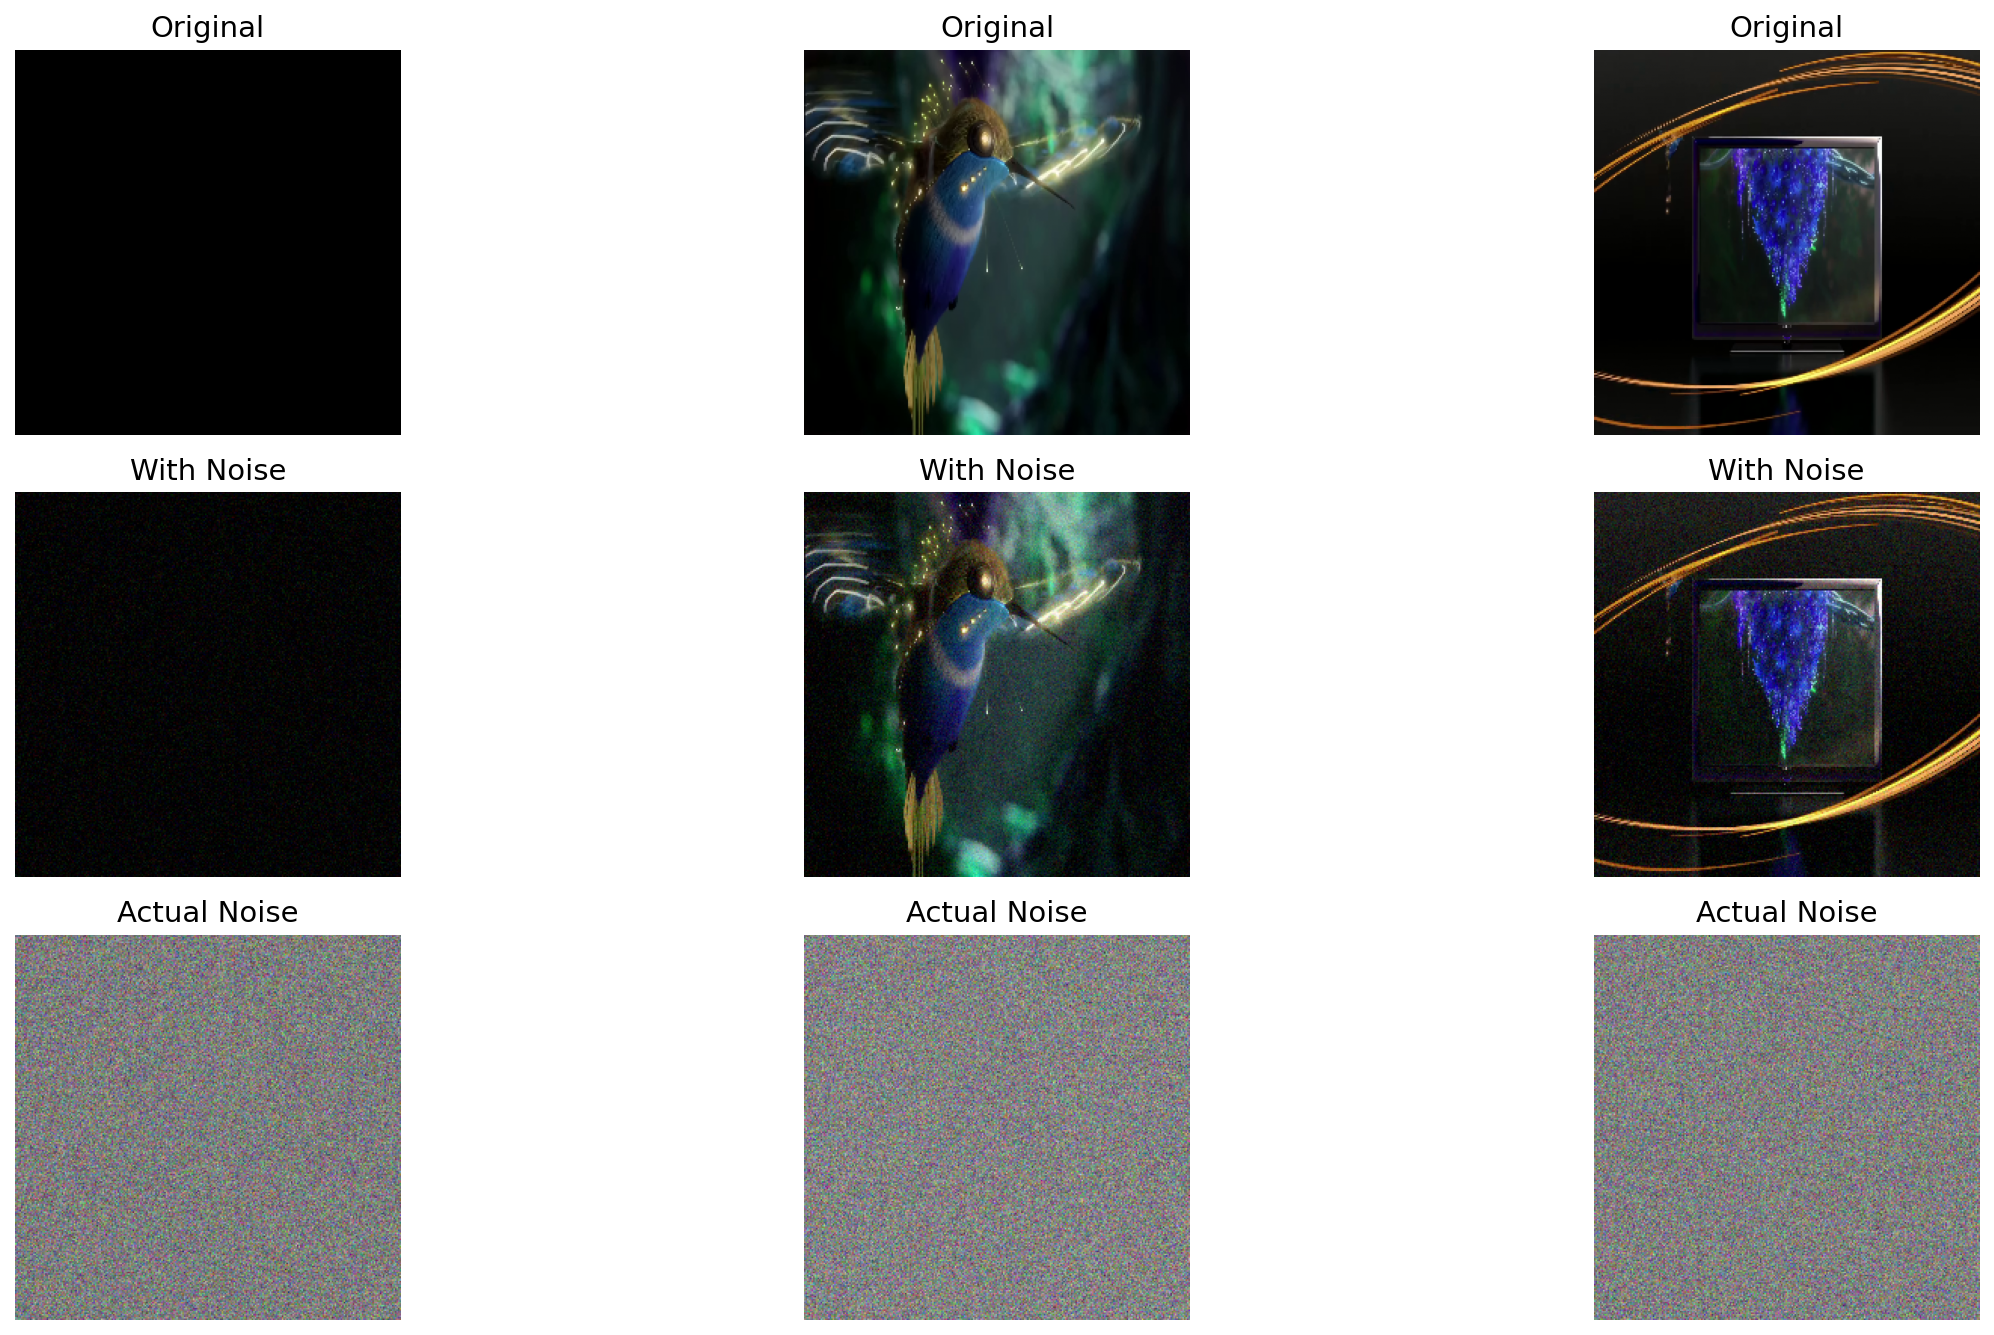

In [23]:
# Show noisy samples
visualize_gaussian_noise(images, noise_level=0.05, n=3)

In [24]:
# Build model
autoencoder = build_autoencoder()

In [25]:
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_3 (GaussianNoise)     │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 64, 64, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128, 128, 64)        │             2

 Total params: 1,335,043 (5.09 MB)

 Trainable params: 1,333,251 (5.09 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 255ms/step - loss: 0.6998
Epoch 2/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - loss: 0.3842
Epoch 3/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 0.2868
Epoch 4/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - loss: 0.2804
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - loss: 0.2867
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - loss: 0.2836
Epoch 7/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - loss: 0.2748
Epoch 8/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - loss: 0.2823
Epoch 9/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - loss: 0.2702
Epoch 10/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.2796
Epoch 11/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 0.2808
Epoch 12/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 0.2712
Epoch 13/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - loss: 0.2825
Epoch 14/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - loss: 0.2762
Epoch 15/200
56/56 ━━━━━━━━━━━━━━━

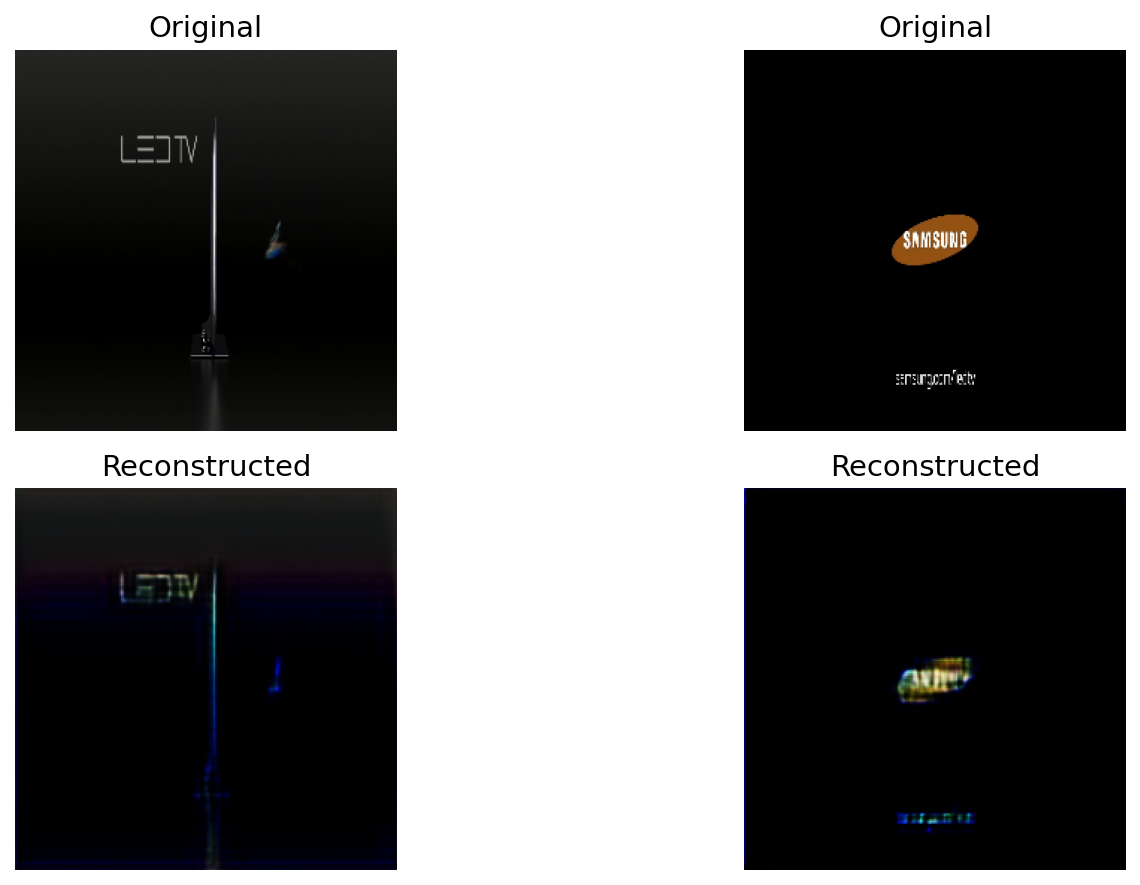

56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - loss: 0.2684
Epoch 51/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - loss: 0.2737
Epoch 52/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 0.2753
Epoch 53/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 0.2715
Epoch 54/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 0.2778
Epoch 55/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.2751
Epoch 56/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 0.2758
Epoch 57/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - loss: 0.2765
Epoch 58/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 0.2662
Epoch 59/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 0.2748
Epoch 60/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.2678
Epoch 61/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 0.2751
Epoch 62/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 0.2748
Epoch 63/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 0.2752
Epoch 64/200
56/56 ━━━━━━━━━━━━━━━━━

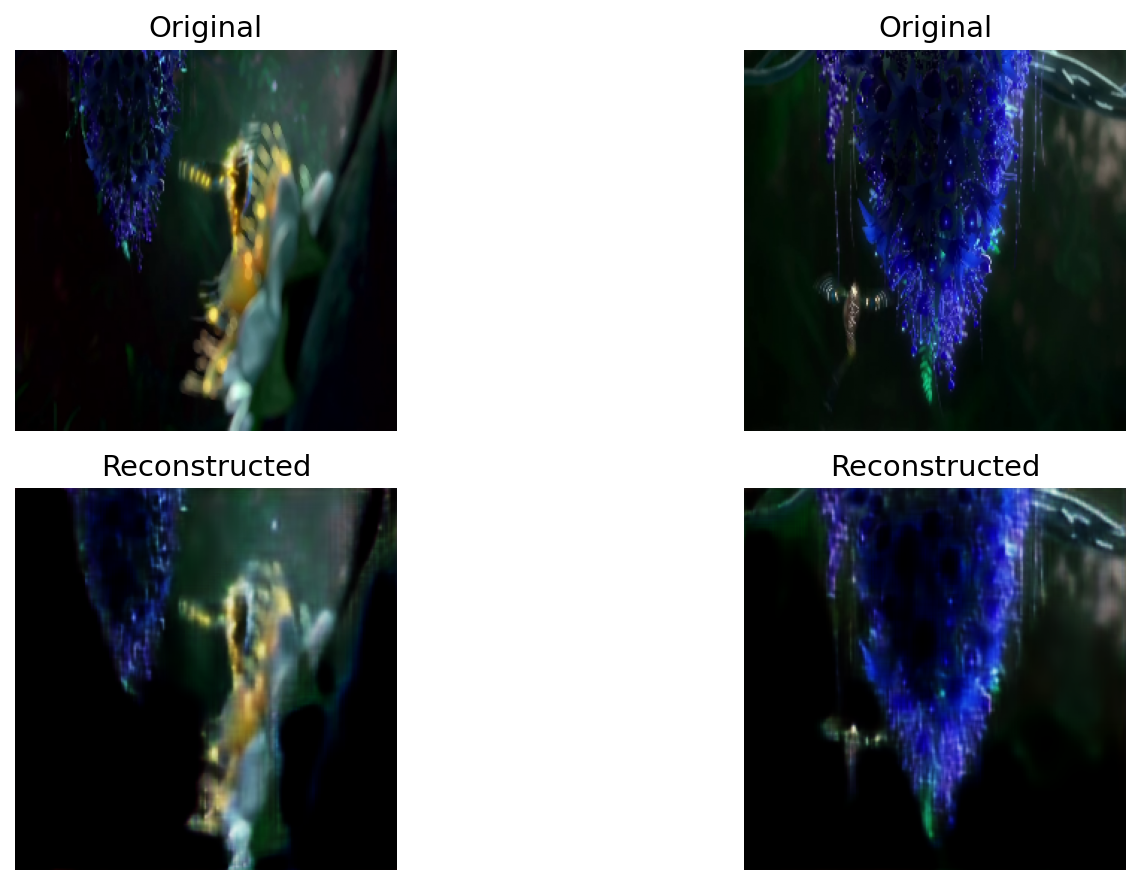

56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - loss: 0.2674
Epoch 101/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 0.2762
Epoch 102/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 0.2774
Epoch 103/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.2682
Epoch 104/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 0.2725
Epoch 105/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.2724
Epoch 106/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 0.2623
Epoch 107/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.2753
Epoch 108/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 0.2680
Epoch 109/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 0.2767
Epoch 110/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - loss: 0.2702
Epoch 111/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 0.2751
Epoch 112/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 0.2729
Epoch 113/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.2724
Epoch 114/200
56/56 ━━━━━━━

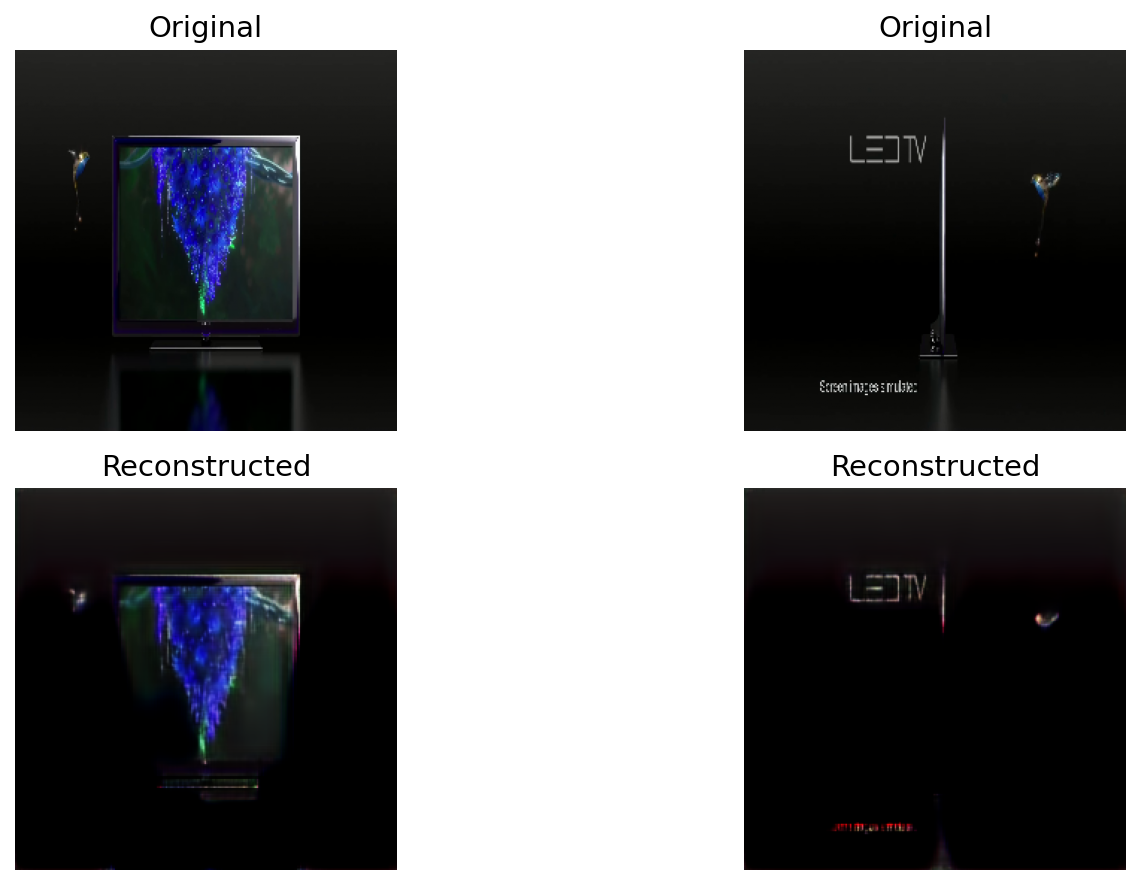

56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - loss: 0.2642
Epoch 151/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 0.2730
Epoch 152/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 0.2716
Epoch 153/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 0.2726
Epoch 154/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.2733
Epoch 155/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 0.2653
Epoch 156/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.2757
Epoch 157/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 0.2620
Epoch 158/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 0.2701
Epoch 159/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.2699
Epoch 160/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 0.2753
Epoch 161/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.2702
Epoch 162/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 0.2661
Epoch 163/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 0.2729
Epoch 164/200
56/56 ━━━━━━

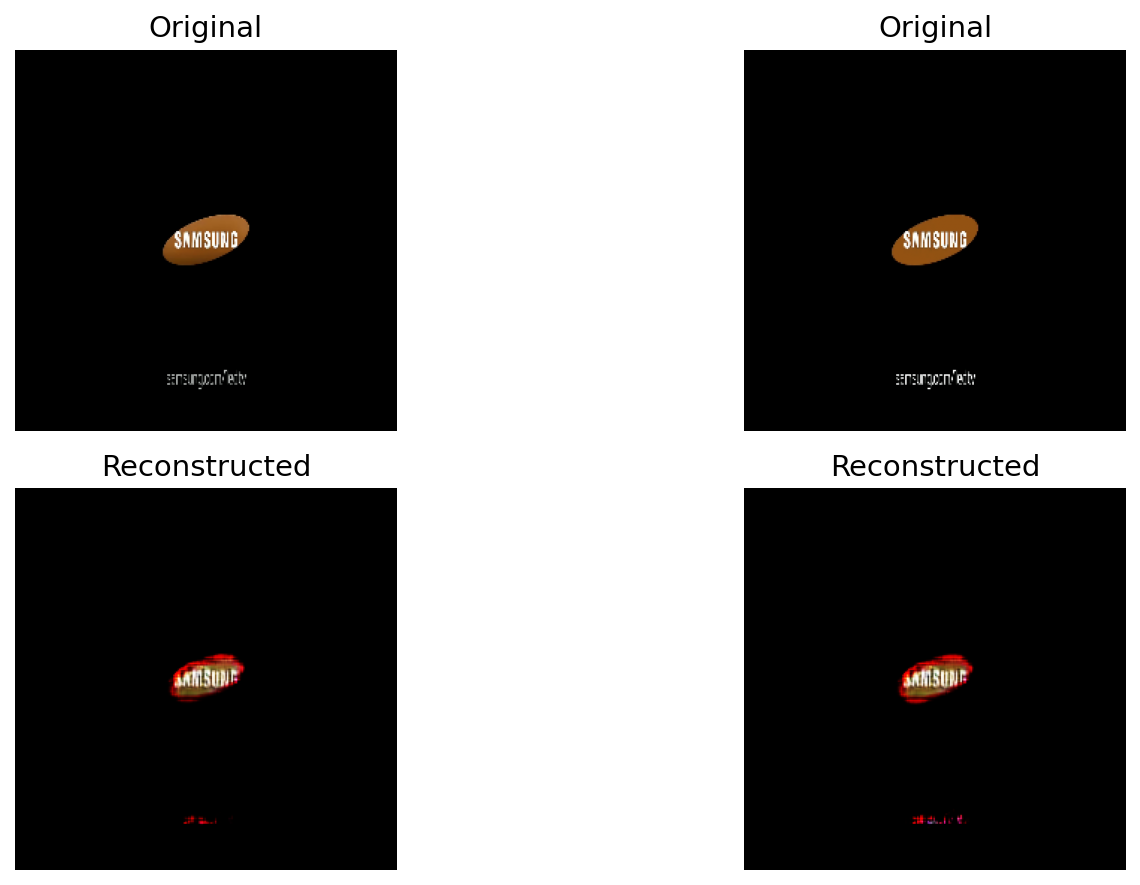

56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - loss: 0.2729


In [26]:
# Train model with callback
autoencoder.fit(
    images, images,
    epochs=200,
    batch_size=16,
    shuffle=True,
    callbacks=[RandomDisplayCallback(images, sample_size=2)]
)


### Saving the model

In [27]:
# Save the model to a file
autoencoder.save('autoencoder_model.h5')

### Testing on a low light video with noise

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import random
import os

In [3]:
# Load the trained autoencoder
model = load_model('autoencoder_model.h5')  # Path to your trained model

In [4]:
# Input & Output video paths
input_path = "Test Videos\pixel4_nightsight_01.mp4"
output_path = 'denoised_output.mp4'

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Adit Punamiya\AppData\Local\Temp\ipykernel_25752\306257243.py:2: SyntaxWarning: invalid escape sequence '\p'
  input_path = "Test Videos\pixel4_nightsight_01.mp4"


In [5]:
# Open video
cap = cv2.VideoCapture(input_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
target_size = (256, 256)

In [6]:
# Output writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

In [7]:
# For visualization
all_original = []
all_denoised = []


In [8]:
for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break

    # Resize and normalize
    resized = cv2.resize(frame, target_size)
    norm = resized / 255.0
    input_img = np.expand_dims(norm, axis=0)

    # Denoise using model
    denoised = model.predict(input_img)[0]

    # Upscale to original resolution using cubic interpolation
    denoised_rescaled = (denoised * 255).astype(np.uint8)
    denoised_frame = cv2.resize(denoised_rescaled, (width, height), interpolation=cv2.INTER_CUBIC)

    # Save output frame
    out.write(denoised_frame)

    # Store frames for comparison
    if i < 100:
        all_original.append(frame)
        all_denoised.append(denoised_frame)

cap.release()
out.release()
print("Video saved as:", output_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

### Visualisation of the new video generated without noise

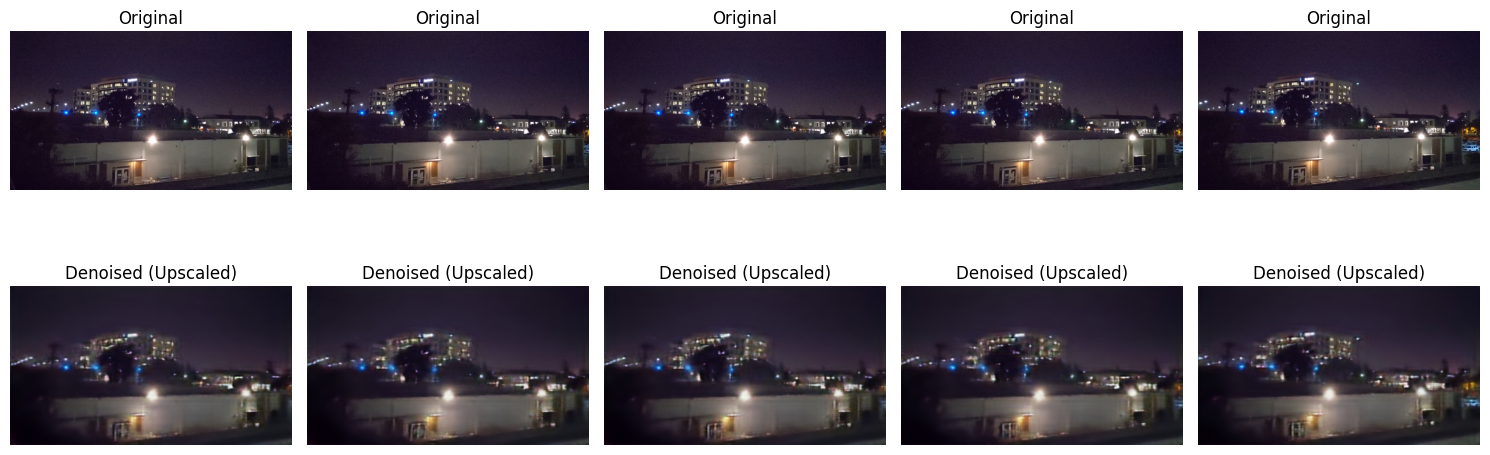

In [9]:
indices = sorted(random.sample(range(len(all_original)), 5))
plt.figure(figsize=(15, 6))

for i, idx in enumerate(indices):
    # Original
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(all_original[idx], cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')

    # Denoised
    plt.subplot(2, 5, i + 6)
    plt.imshow(cv2.cvtColor(all_denoised[idx], cv2.COLOR_BGR2RGB))
    plt.title("Denoised (Upscaled)")
    plt.axis('off')

plt.tight_layout()
plt.show()


### Evaluation of the Model

In [11]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Convert frames to Y-channel (grayscale) for better perceptual SSIM/PSNR
def preprocess_for_metrics(bgr_frame):
    rgb = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    return rgb.astype(np.float32) / 255.0  # Normalize to [0,1]

# Evaluate PSNR & SSIM
psnr_total = 0
ssim_total = 0
num_eval = len(all_original)

print("\nEvaluating PSNR & SSIM on first", num_eval, "frames...")

for i in range(num_eval):
    original = preprocess_for_metrics(all_original[i])
    denoised = preprocess_for_metrics(all_denoised[i])

    # Compute PSNR & SSIM
    psnr_val = psnr(original, denoised, data_range=1.0)
    ssim_val = ssim(original, denoised, channel_axis=-1, data_range=1.0)

    psnr_total += psnr_val
    ssim_total += ssim_val

    if i % 20 == 0:
        print(f"Frame {i}: PSNR = {psnr_val:.2f}, SSIM = {ssim_val:.4f}")

# Average Metrics
psnr_auto = psnr_total / num_eval
ssim_auto = ssim_total / num_eval

print(f"\n Average PSNR: {psnr_auto:.2f}")
print(f" Average SSIM: {ssim_auto:.4f}")



Evaluating PSNR & SSIM on first 100 frames...
Frame 0: PSNR = 26.80, SSIM = 0.8186
Frame 20: PSNR = 26.81, SSIM = 0.8432
Frame 40: PSNR = 26.80, SSIM = 0.8444
Frame 60: PSNR = 26.69, SSIM = 0.8318
Frame 80: PSNR = 26.79, SSIM = 0.8429

 Average PSNR: 26.77
 Average SSIM: 0.8424


## Comapring with Basic Image/Video processing techniques

### Code

In [22]:
import cv2
import numpy as np

def apply_mean_filter_color(frame):
    frame = frame.astype(np.float32)

    # Apply filter to each channel separately
    filtered = np.zeros_like(frame)
    for c in range(3):  # For R, G, B channels
        channel = frame[:, :, c]
        padded = np.pad(channel, ((1, 1), (1, 1)), mode='edge')
        smoothed = sum(
            padded[i:i + frame.shape[0], j:j + frame.shape[1]]
            for i in range(3) for j in range(3)
        ) / 9.0
        filtered[:, :, c] = smoothed

    return np.clip(filtered, 0, 255).astype(np.uint8)

# Load input video
cap = cv2.VideoCapture('/content/pixel4_nightsight_01.mp4')

# Video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Output writer for MP4 with color
out = cv2.VideoWriter('denoised_output_ML.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height), isColor=True)

original_frames = []
filtered_frames = []

frame_idx = 0
print("Processing and evaluating...")

while cap.isOpened() and frame_idx < 100:
    ret, frame = cap.read()
    if not ret:
        break

    denoised_frame = apply_mean_filter_color(frame)
    out.write(denoised_frame)

    original_frames.append(frame.astype(np.float32) / 255.0)
    filtered_frames.append(denoised_frame.astype(np.float32) / 255.0)
    frame_idx += 1

cap.release()
out.release()
cv2.destroyAllWindows()
print(" Denoising complete. Saved as 'denoised_output_ML.mp4'")


Processing and evaluating...
 Denoising complete. Saved as 'denoised_output_ML.mp4'


In [13]:
psnr_mean = []
ssim_mean = []

for i in range(len(original_frames)):
    ori = np.clip(original_frames[i], 0, 1)
    filt = np.clip(filtered_frames[i], 0, 1)

    psnr_mean.append(psnr(ori, filt, data_range=1.0))
    ssim_mean.append(ssim(ori, filt, channel_axis=2, data_range=1.0))

print(f"\nMean Filter PSNR: {np.mean(psnr_mean):.2f} dB")
print(f"Mean Filter SSIM: {np.mean(ssim_mean):.4f}")


Mean Filter PSNR: nan dB
Mean Filter SSIM: nan


c:\Users\Adit Punamiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Adit Punamiya\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [19]:
# Step 3: Download the output video from Colab
from google.colab import files
files.download('denoised_output_ML.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Comparison with Autoencoder

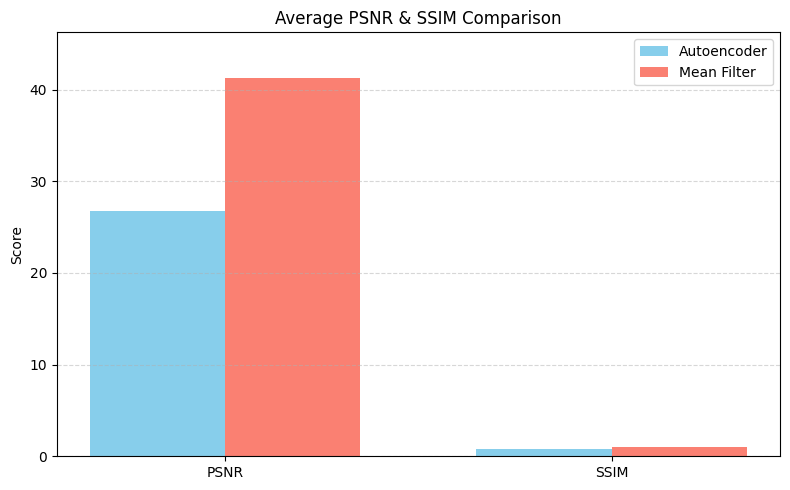


--- Comparison Table ---
     Method  Average PSNR  Average SSIM
Autoencoder         26.77        0.8424
Mean Filter         41.26        0.9874


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Use your actual average values here
avg_psnr_auto = 26.77
avg_ssim_auto = 0.8424

avg_psnr_mean = 41.26
avg_ssim_mean = 0.9874

# Bar chart
labels = ['PSNR', 'SSIM']
auto_vals = [avg_psnr_auto, avg_ssim_auto]
mean_vals = [avg_psnr_mean, avg_ssim_mean]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, auto_vals, width, label='Autoencoder', color='skyblue')
plt.bar(x + width/2, mean_vals, width, label='Mean Filter', color='salmon')
plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Average PSNR & SSIM Comparison")
plt.legend()
plt.ylim(0, max(auto_vals + mean_vals) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Text Table
data = {
    "Method": ["Autoencoder", "Mean Filter"],
    "Average PSNR": [avg_psnr_auto, avg_psnr_mean],
    "Average SSIM": [avg_ssim_auto, avg_ssim_mean],
}
df = pd.DataFrame(data)
print("\n--- Comparison Table ---")
print(df.to_string(index=False))


<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Adit Punamiya\AppData\Local\Temp\ipykernel_25752\3842721330.py:6: SyntaxWarning: invalid escape sequence '\p'
  original_video_path = 'Test Videos\pixel4_nightsight_01.mp4'
C:\Users\Adit Punamiya\AppData\Local\Temp\ipykernel_25752\3842721330.py:8: SyntaxWarning: invalid escape sequence '\d'
  mean_filtered_video_path = 'ML output\denoised_output_ML.mp4'


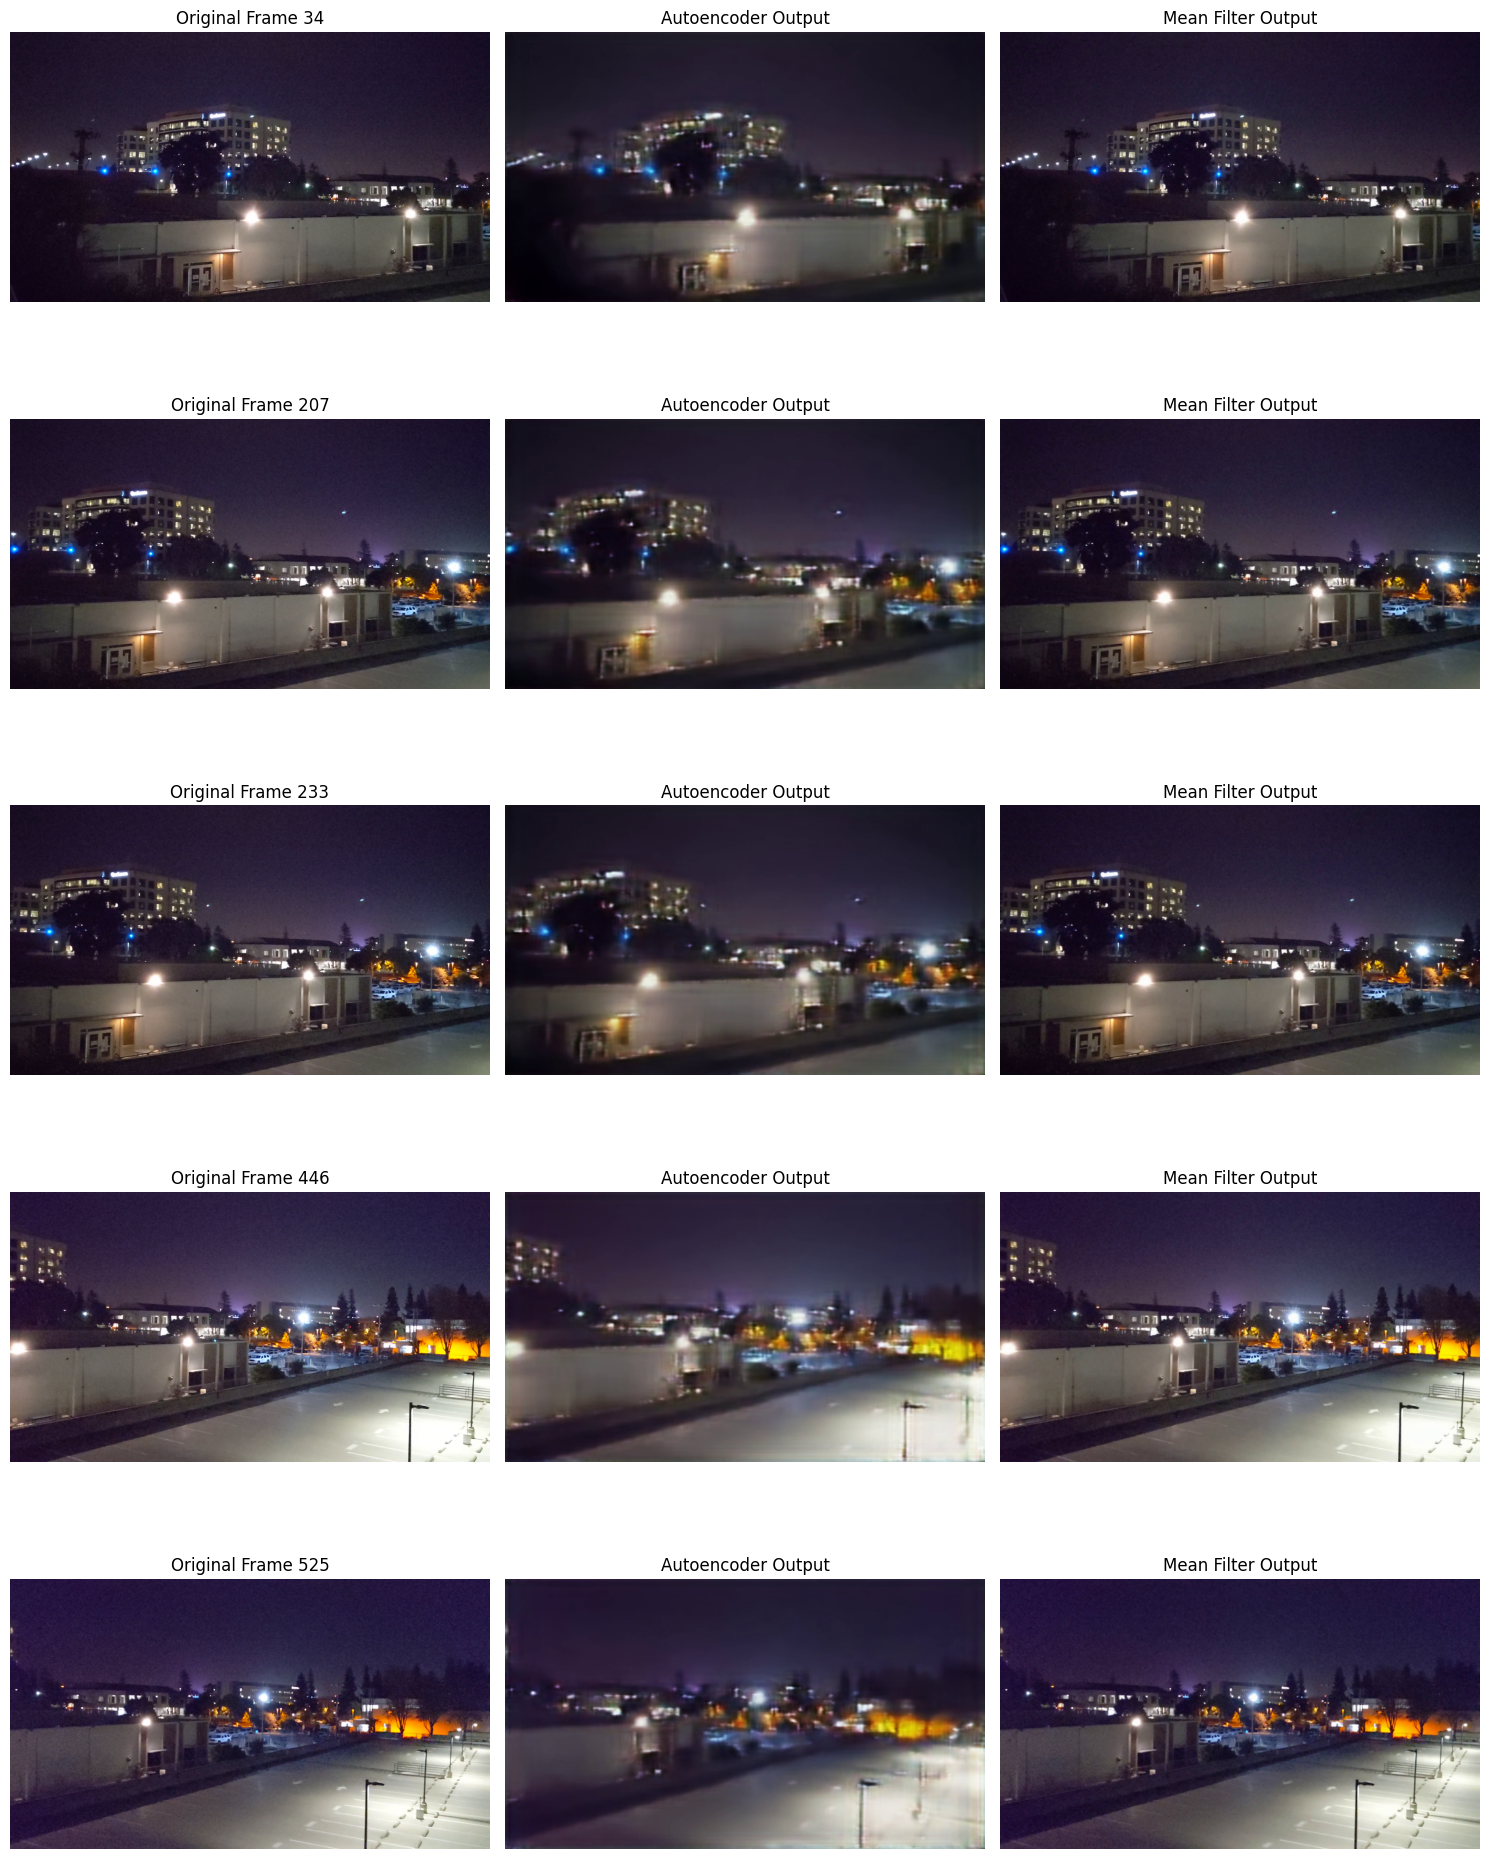

In [23]:
import cv2
import matplotlib.pyplot as plt
import random

# Paths to videos
original_video_path = 'Test Videos\pixel4_nightsight_01.mp4'
autoencoder_video_path = 'denoised_output.mp4'
mean_filtered_video_path = 'ML output\denoised_output_ML.mp4'

# Load videos
original_cap = cv2.VideoCapture(original_video_path)
auto_cap = cv2.VideoCapture(autoencoder_video_path)
mean_cap = cv2.VideoCapture(mean_filtered_video_path)

# Get total number of frames (assume all videos have same frame count)
frame_count = int(original_cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Pick random frame indices to visualize
num_samples = 5
indices = sorted(random.sample(range(frame_count), num_samples))

# Function to fetch specific frame
def get_frame_at(cap, index):
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    ret, frame = cap.read()
    return frame if ret else None

# Plot comparison
plt.figure(figsize=(15, 4 * num_samples))

for i, idx in enumerate(indices):
    orig = get_frame_at(original_cap, idx)
    auto = get_frame_at(auto_cap, idx)
    mean = get_frame_at(mean_cap, idx)

    if orig is None or auto is None or mean is None:
        continue  # skip if any frame failed to load

    # Convert to RGB for display
    orig_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    auto_rgb = cv2.cvtColor(auto, cv2.COLOR_BGR2RGB)
    mean_rgb = cv2.cvtColor(mean, cv2.COLOR_BGR2RGB)

    # Original
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(orig_rgb)
    plt.title(f"Original Frame {idx}")
    plt.axis('off')

    # Autoencoder Output
    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(auto_rgb)
    plt.title("Autoencoder Output")
    plt.axis('off')

    # Mean Filter Output
    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(mean_rgb)
    plt.title("Mean Filter Output")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Release resources
original_cap.release()
auto_cap.release()
mean_cap.release()
